## Reflectivity and Transmittance of Lossy Media
A lossy material is a material having a complex index of refraction of the form
$$\tilde{n}(\omega) = n(\omega) + i\kappa(\omega)$$
where $\kappa$ is known as the extinction coefficient (due to the fact that it results in an exponential damping of the electromagentic wave amplitude as a function of distance travelled inside said medium). Both the real and imaginary components play an important role in determining the fraction of light that is reflected and transmitted for a given wavelength and angle of incidence. Both the real and imaginary parts of $\tilde{n}$ are functions of the incident wave's frequency (and therefore wavelength).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data_frame = pd.read_csv('csv//Copper - Stahrenberg.csv')
scale_factor = 1000  # micrometers to nanometers
wavelengths = scale_factor * data_frame.iloc[:, 0].values
refractive_index_real = data_frame.iloc[:, 1].values

if len(data_frame.columns) > 2:
    # Extract the third column values
    refractive_index_imaginary = data_frame.iloc[:, 2].values
    refractive_index_complex = (
        refractive_index_real + 1j * refractive_index_imaginary
    )
else:
    refractive_index_complex = refractive_index_real


refractive_index = refractive_index_complex # rename

Here, we want to determine the reflectivity and transmittance of light from vacuum incident upon lossy media, such as copper or other metals. From raw refractive index data, we can extract the real and imaginary components of the dielectric constant thanks to the relation:
$$\tilde{\epsilon} = \epsilon' + i\epsilon'' = (n + i\kappa)^2$$
which, upon expanding, leaves us with
$$\epsilon' = n^2 - \kappa^2 \hspace{2cm} \epsilon'' = 2n\kappa$$
Furthermore, each material has a characteristic impedance, defined as
$$Z = \frac{Z_0}{\sqrt{\tilde{\epsilon}}}$$
where: $\newline$
$Z_0 = \sqrt{\frac{\mu_0}{\epsilon_0}} = 377 \Omega\newline$
$\epsilon_0 = 8.854 \times 10^{-12} \frac{C^2}{Nm^2} \newline$
$\mu_0 = 4 \pi \times 10^{-7} \frac{H}{m}\newline$

In [3]:
# Constants
epsilon_0 = 8.854e-12
mu_0 = 4 * np.pi * 1e-7
characteristic_impedance_0 = np.sqrt(mu_0 / epsilon_0)
epsilon_1 = epsilon_0 # incident material is free space
characteristic_impedance_1 = characteristic_impedance_0 # incident material is free space

incident_angle = np.linspace(0, np.pi / 2, 1000)

epsilon_2_real = np.real(refractive_index) ** 2 - np.imag(refractive_index)**2
epsilon_2_imaginary = 2 * np.real(refractive_index) * np.imag(refractive_index)
epsilon_2 = epsilon_2_real + 1j * epsilon_2_imaginary

characteristic_impedance_2 = characteristic_impedance_0 / np.sqrt(epsilon_2)

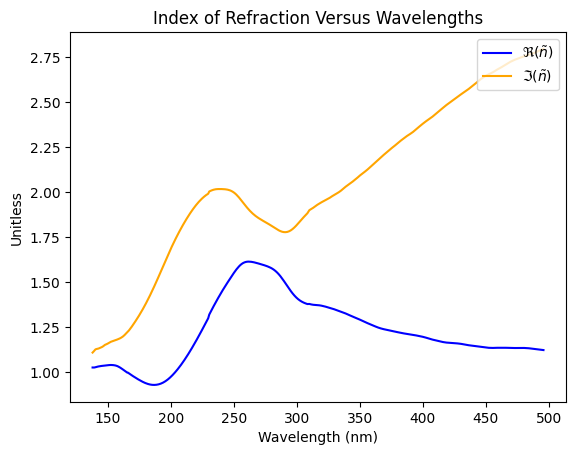

In [4]:
# Plot the index of refraction
plt.plot(wavelengths, np.real(refractive_index), label="$\Re(\\tilde{n})$", color = "blue")
plt.plot(wavelengths, np.imag(refractive_index), label="$\Im(\\tilde{n})$", color = "orange")
plt.title("Index of Refraction Versus Wavelengths")
plt.savefig("two sides.png", transparent=True)
plt.ylabel("Unitless")
plt.xlabel("Wavelength (nm)")
plt.legend(loc="upper right")


From here, we can determine the reflectivity and transmittance directly using the relations:
$$R_s = \left|\frac{Z_2\cos(\theta_i) - Z_1\cos(\theta_t)}{Z_2\cos(\theta_i) + Z_1\cos(\theta_t)}\right|^2$$
for S-polarized light, and
$$R_p = \left|\frac{Z_2\cos(\theta_t) - Z_1\cos(\theta_i)}{Z_2\cos(\theta_t) + Z_1\cos(\theta_i)}\right|^2$$
for P-polarized light. The transmittance is simply given by
$$T = 1 - R$$
for either polarization. Here, $\theta_i$ is the incident angle, $\theta_t$ is the transmitted angle, and $Z_1$ and $Z_2$ are the characteristic impedances of media 1 and 2 respectively (and so for our purposes $Z_1 = Z_0$). These equations are valid under the assumption that the material in question is non-magnetic (i.e $\mu_1 = \mu_2 = \mu_0$).

We can make use of a handy relation which expresses $\cos(\theta_t)$ in terms of $\theta_i$:
$$\cos(\theta_t) = \sqrt{1 - \left(\frac{\epsilon_1'}{\epsilon_2' - i\epsilon_2''}\right)\sin^2\theta_1}$$

(these equations are all taken from http://cobalt.cneas.tohoku.ac.jp/users/sato/Ch2-EMwave.pdf section 2-9)

In [5]:


def cos_theta_transmitted(incident_angle, epsilon_2):
    return np.sqrt(1 - (epsilon_1 / epsilon_2) * np.sin(incident_angle) ** 2)

def R_s(incident_angle, characteristic_impedance_2, epsilon_2):
    return abs((characteristic_impedance_2 * np.cos(incident_angle) - characteristic_impedance_1 * cos_theta_transmitted(incident_angle, epsilon_2)) / 
               (characteristic_impedance_2 * np.cos(incident_angle) + characteristic_impedance_1 * cos_theta_transmitted(incident_angle, epsilon_2))) ** 2

def T_s(incident_angle, characteristic_impedance_2, epsilon_2):
    return 1 - R_s(incident_angle, characteristic_impedance_2, epsilon_2)
def R_p(incident_angle, characteristic_impedance_2, epsilon_2):
    return abs((characteristic_impedance_2 * cos_theta_transmitted(incident_angle, epsilon_2) - characteristic_impedance_1 * np.cos(incident_angle)) /
               (characteristic_impedance_2 * cos_theta_transmitted(incident_angle, epsilon_2) + characteristic_impedance_1 * np.cos(incident_angle))) ** 2
    
def T_p(incident_angle, characteristic_impedance_2, epsilon_2):
    return 1 - R_p(incident_angle, characteristic_impedance_2, epsilon_2)


In [6]:

incident_angle = np.linspace(0, np.pi / 2, 1000)

incident_angle_mesh, wavelengths_mesh = np.meshgrid(incident_angle, wavelengths)
incident_angle_mesh, characteristic_impedance_2_mesh = np.meshgrid(incident_angle, characteristic_impedance_2)
incident_angle_mesh, epsilon_2_mesh = np.meshgrid(incident_angle, epsilon_2)

reflection_coefficient_s = R_s(incident_angle_mesh, characteristic_impedance_2_mesh, epsilon_2_mesh)
reflection_coefficient_p = R_p(incident_angle_mesh, characteristic_impedance_2_mesh, epsilon_2_mesh)
transmission_coefficient_s = T_s(incident_angle_mesh, characteristic_impedance_2_mesh, epsilon_2_mesh)
transmission_coefficient_p = T_p(incident_angle_mesh, characteristic_impedance_2_mesh, epsilon_2_mesh)

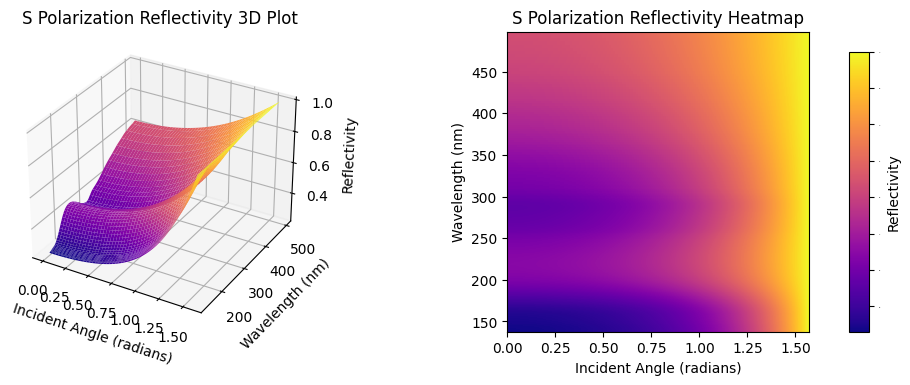

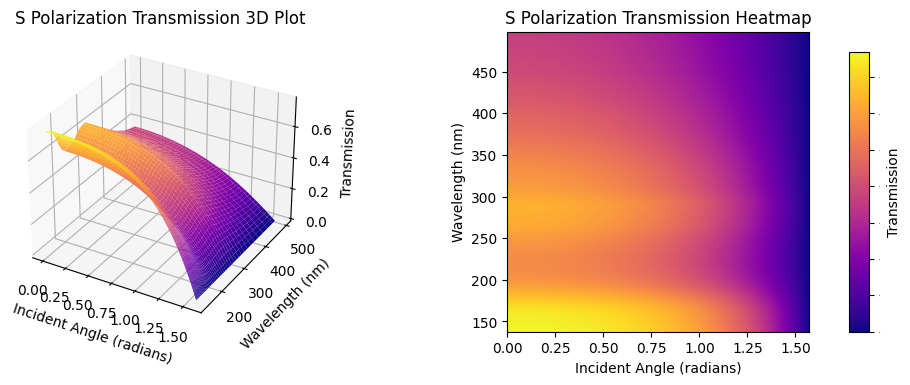

In [11]:
# Create 3D reflectivity plot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(incident_angle_mesh, wavelengths_mesh, reflection_coefficient_s, cmap='plasma')
ax.set_xlabel('Incident Angle (radians)')
ax.set_ylabel('Wavelength (nm)')
ax.set_zlabel('Reflectivity')
ax.set_title('S Polarization Reflectivity 3D Plot')

# Create reflectivity heatmap
ax = fig.add_subplot(122)
heatmap = ax.pcolormesh(incident_angle_mesh, wavelengths_mesh, reflection_coefficient_s, shading='auto', cmap='plasma')
ax.set_xlabel('Incident Angle (radians)')
ax.set_ylabel('Wavelength (nm)')
ax.set_title('S Polarization Reflectivity Heatmap')

# Add colorbar for the heatmap
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(heatmap, cax=cbar_ax, label='Reflectivity')

# Adjust subplot spacing
fig.subplots_adjust(left=0.08, right=0.88, top=0.9, bottom=0.15, wspace=0.65)

# Adjust the font size of the axis numbers
plt.tick_params(axis='both', which='major', labelsize=0.5)

# Show the plots
plt.show()

# Create 3D transmission plot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(incident_angle_mesh, wavelengths_mesh, transmission_coefficient_s, cmap='plasma')
ax.set_xlabel('Incident Angle (radians)')
ax.set_ylabel('Wavelength (nm)')
ax.set_zlabel('Transmission')
ax.set_title('S Polarization Transmission 3D Plot')

# Create transmission heatmap
ax = fig.add_subplot(122)
heatmap = ax.pcolormesh(incident_angle_mesh, wavelengths_mesh, transmission_coefficient_s, shading='auto', cmap='plasma')
ax.set_xlabel('Incident Angle (radians)')
ax.set_ylabel('Wavelength (nm)')
ax.set_title('S Polarization Transmission Heatmap')

# Add colorbar for the heatmap
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(heatmap, cax=cbar_ax, label='Transmission')

# Adjust subplot spacing
fig.subplots_adjust(left=0.08, right=0.88, top=0.9, bottom=0.15, wspace=0.65)

# Adjust the font size of the axis numbers
plt.tick_params(axis='both', which='major', labelsize=0.5)

# Show the plots
plt.show()

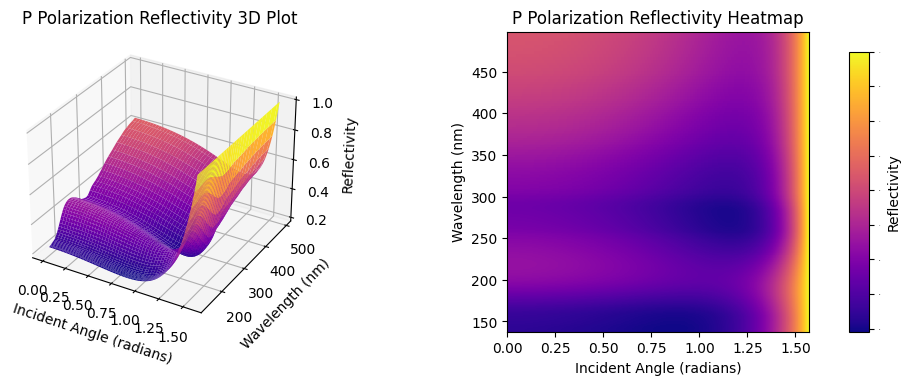

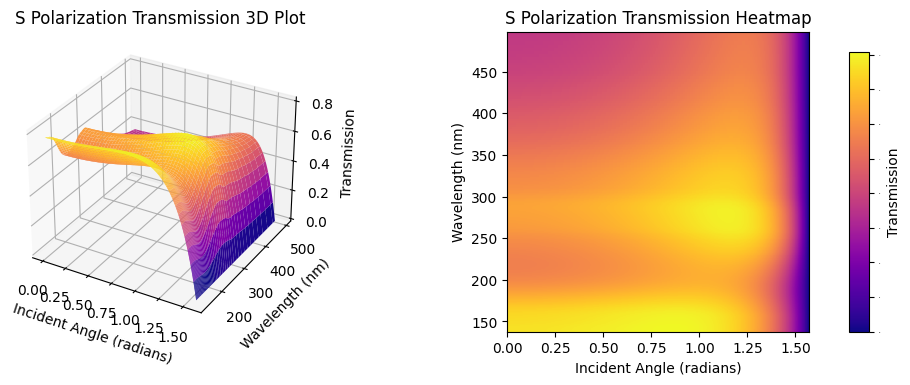

In [12]:
# Create 3D plot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(incident_angle_mesh, wavelengths_mesh, reflection_coefficient_p, cmap='plasma')
ax.set_xlabel('Incident Angle (radians)')
ax.set_ylabel('Wavelength (nm)')
ax.set_zlabel('Reflectivity')
ax.set_title('P Polarization Reflectivity 3D Plot')

# Create heatmap
ax = fig.add_subplot(122)
heatmap = ax.pcolormesh(incident_angle_mesh, wavelengths_mesh, reflection_coefficient_p, shading='auto', cmap='plasma')
ax.set_xlabel('Incident Angle (radians)')
ax.set_ylabel('Wavelength (nm)')
ax.set_title('P Polarization Reflectivity Heatmap')

# Add colorbar for the heatmap
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(heatmap, cax=cbar_ax, label='Reflectivity')

# Adjust subplot spacing
fig.subplots_adjust(left=0.08, right=0.88, top=0.9, bottom=0.15, wspace=0.65)

# Adjust the font size of the axis numbers
plt.tick_params(axis='both', which='major', labelsize=0.5)

# Show the plots
plt.show()

# Create 3D transmission plot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(incident_angle_mesh, wavelengths_mesh, transmission_coefficient_p, cmap='plasma')
ax.set_xlabel('Incident Angle (radians)')
ax.set_ylabel('Wavelength (nm)')
ax.set_zlabel('Transmission')
ax.set_title('S Polarization Transmission 3D Plot')

# Create transmission heatmap
ax = fig.add_subplot(122)
heatmap = ax.pcolormesh(incident_angle_mesh, wavelengths_mesh, transmission_coefficient_p, shading='auto', cmap='plasma')
ax.set_xlabel('Incident Angle (radians)')
ax.set_ylabel('Wavelength (nm)')
ax.set_title('S Polarization Transmission Heatmap')

# Add colorbar for the heatmap
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(heatmap, cax=cbar_ax, label='Transmission')

# Adjust subplot spacing
fig.subplots_adjust(left=0.08, right=0.88, top=0.9, bottom=0.15, wspace=0.65)

# Adjust the font size of the axis numbers
plt.tick_params(axis='both', which='major', labelsize=0.5)

# Show the plots
plt.show()